<a href="https://colab.research.google.com/github/shivi8302/OIBSIP/blob/main/LEVEL2_TAKS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTALLING LIBRARIES

In [ ]:
!pip install squarify wordcloud textblob plotly scikit-learn matplotlib seaborn
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
!pip install -U pip setuptools wheel
!pip install textblob --no-cache-dir

In [ ]:
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


#Imports + upload files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import re
from google.colab import files

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10,6)

uploaded = files.upload()
apps = pd.read_csv("apps.csv")

Saving apps.csv to apps (2).csv


In [ ]:
uploaded = files.upload()
reviews = pd.read_csv("user_reviews.csv")

Saving user_reviews.csv to user_reviews.csv


##Quick look & cleanup basics

In [ ]:
apps.head()
apps.info()
reviews.head()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            8432 non-null   float64
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #

####Drop stray index column, unity column names

In [ ]:
if 'Unnamed: 0' in apps.columns:
    apps = apps.drop(columns=['Unnamed: 0'])

apps.columns = [c.strip() for c in apps.columns]
reviews.columns = [c.strip() for c in reviews.columns]

print("apps:", apps.shape, "reviews:", reviews.shape)

apps: (9659, 13) reviews: (64295, 5)


##Robust cleaning / type conversions

In [ ]:
apps['Price'] = apps['Price'].astype(str).replace('[\$]', '', regex=True)
apps['Price'] = apps["Price"].replace('Free', '0', regex = False)
apps['Price'] = pd.to_numeric(apps['Price'], errors = 'coerce')

apps['Install'] = apps['Installs'].astype(str).str.replace('[+,]', '', regex = True)
apps['Install'] = pd.to_numeric(apps['Install'], errors='coerce').fillna(0).astype(int)

apps['Reviews'] = pd.to_numeric(apps['Reviews'], errors='coerce').fillna(0).astype(int)
apps['Rating'] = pd.to_numeric(apps['Rating'], errors='coerce')

def size_to_mb(x):
  if pd.isna(x): return np.nan
  s = str(x).strip()
  if s in ['Varies with device', 'Varies with device.']:
    return np.nan
  if s.endswith('M'):
    try: return float(s[:-1])
    except: return np.nan
  if s.endswith('k'):
    try: return float(s[:-1])/1024
    except: return np.nan
  try:
    return float(s)
  except:
    return np.nan

apps['Size_MB'] = apps['Size'].apply(size_to_mb)

apps['Last Update'] = pd.to_datetime(apps['Last Updated'], errors = 'coerce')
apps = apps.drop_duplicates(subset = ['App']).reset_index(drop = True)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1583717783.py:1: SyntaxWarning: invalid escape sequence '\$'
  apps['Price'] = apps['Price'].astype(str).replace('[\$]', '', regex=True)


##Basic EDA / Distribution

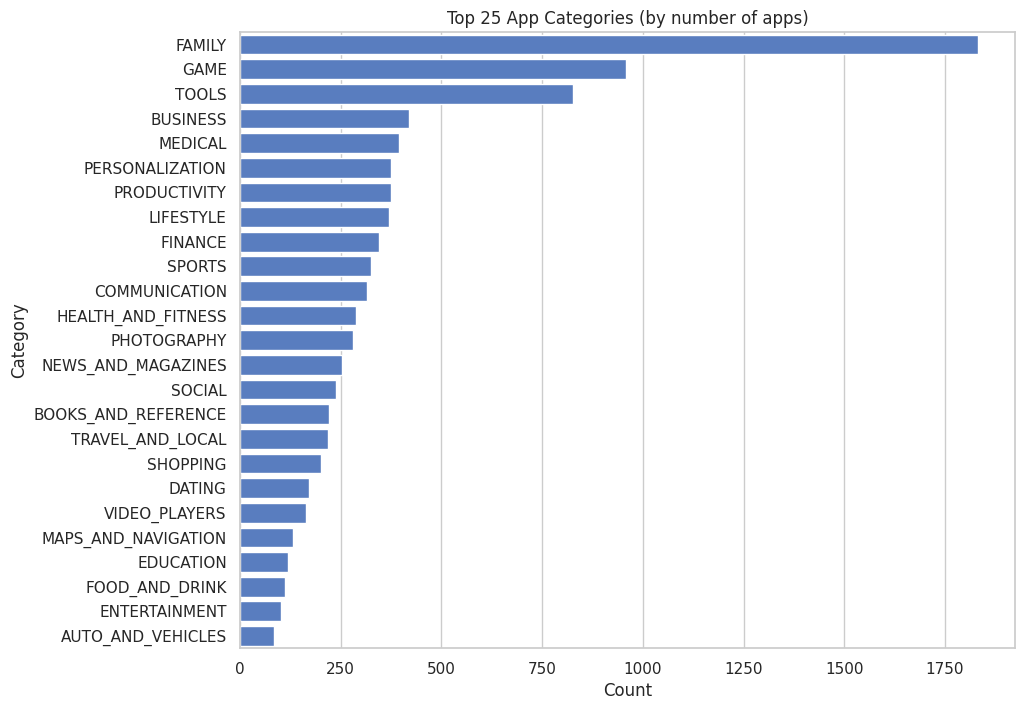

In [ ]:
apps['Category'].value_counts().head(20)

plt.figure(figsize = (10,8))
topcats = apps['Category'].value_counts().nlargest(25).index
sns.countplot(y='Category', data=apps[apps['Category'].isin(topcats)], order = topcats)
plt.title("Top 25 App Categories (by number of apps)")
plt.xlabel("Count")
plt.show()

##Top apps by installs & rating

/tmp/ipython-input-77204087.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Installs', y='App', data=top_installs, palette='viridis')


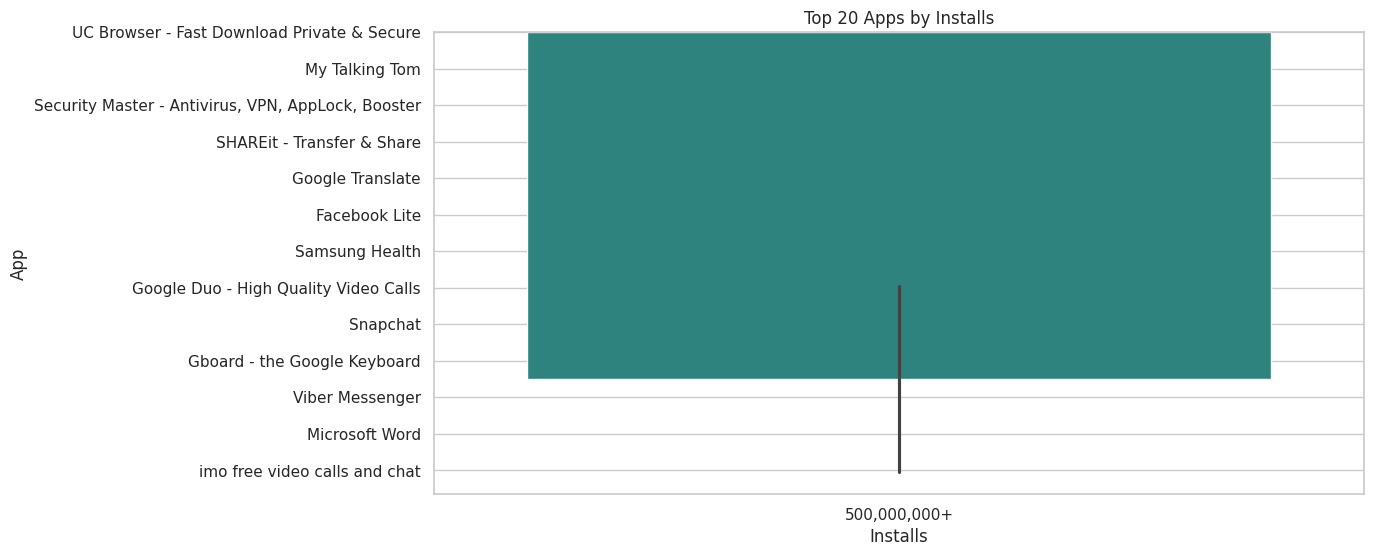

In [ ]:
top_installs = apps.sort_values('Installs', ascending = False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(x='Installs', y='App', data=top_installs, palette='viridis')
plt.title('Top 20 Apps by Installs')
plt.show()

top_rated = apps[apps['Reviews']>1000].sort_values('Rating', ascending = False).head(20)
top_rated[['App','Category', 'Rating', 'Installs', 'Reviews']].head(10)

##Rating distribution + installs vs rating scatter (log scale)

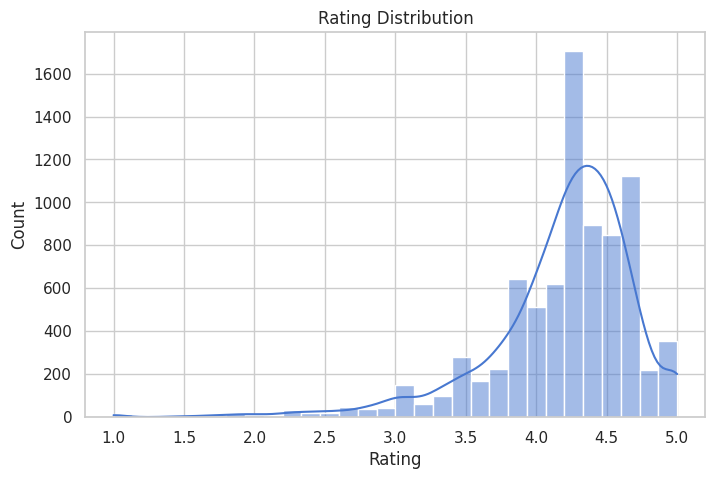

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(apps['Rating'].dropna(), bins=30, kde=True)
plt.title('Rating Distribution')
plt.show()

fig = px.scatter(apps, x='Rating', y='Installs', size='Reviews', color='Category',
                  log_y=True, hover_name='App', title='Rating vs Installs (log scale)')

fig.show()

##Boxplots and violin plots by category (top categories)

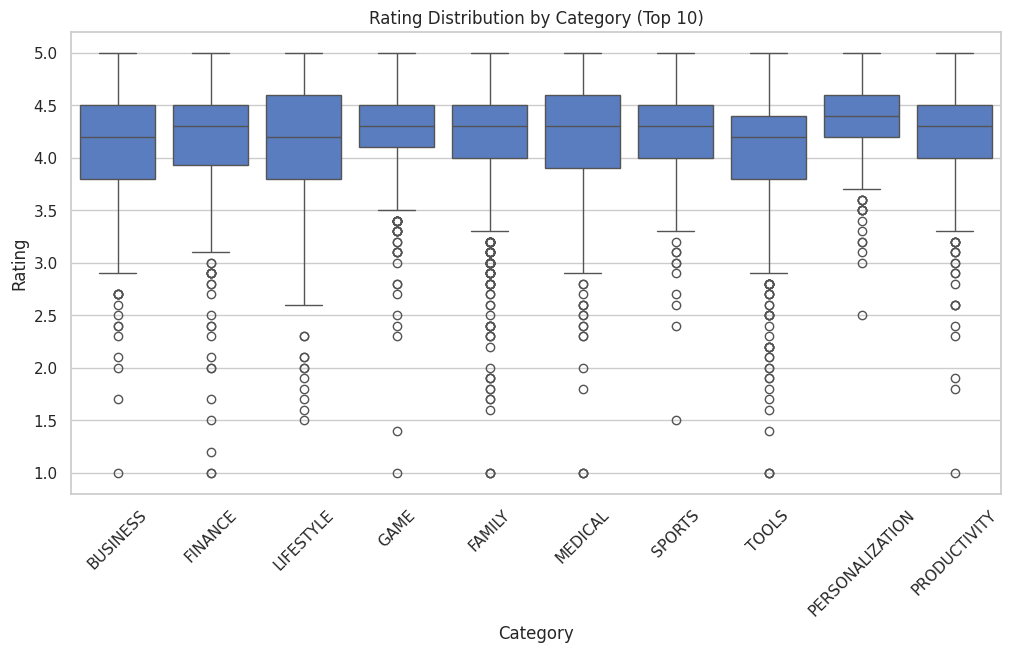

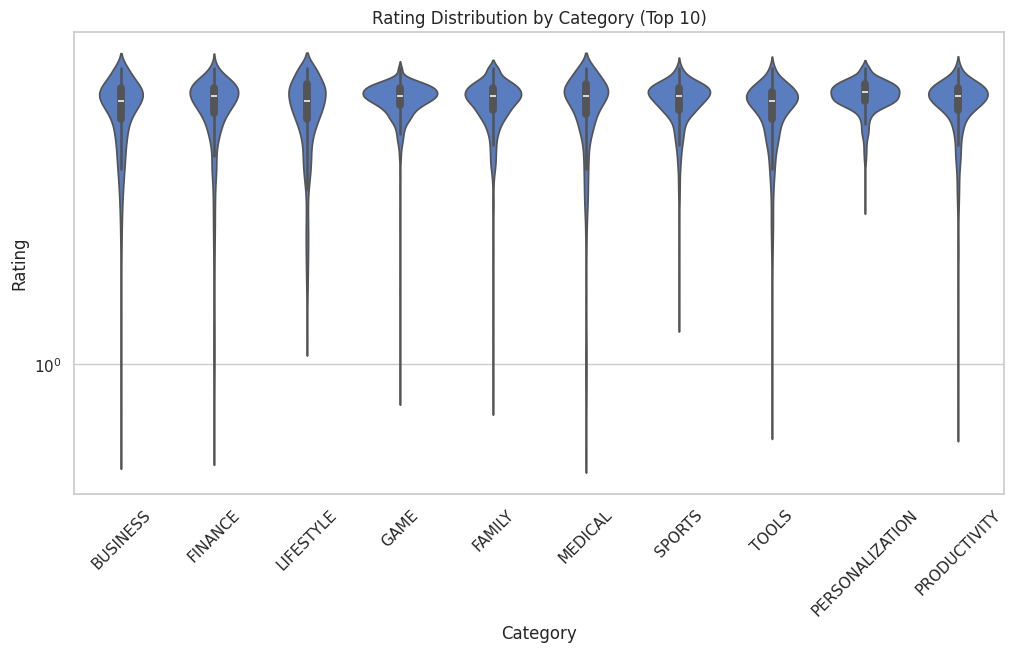

In [ ]:
top10 = apps['Category'].value_counts().nlargest(10).index
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='Rating', data=apps[apps['Category'].isin(top10)])
plt.xticks(rotation=45)
plt.title('Rating Distribution by Category (Top 10)')
plt.show()

plt.figure(figsize=(12,6))
sns.violinplot(x='Category', y='Rating', data=apps[apps['Category'].isin(top10)])
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Rating Distribution by Category (Top 10)')
plt.show()

##Correlation heatmap (numeric feature)

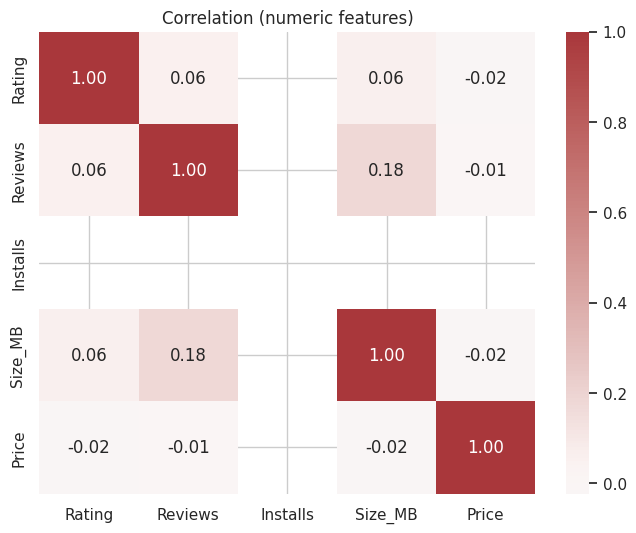

In [ ]:
num = apps[['Rating', 'Reviews', 'Installs', 'Size_MB', 'Price']].copy()
num = num.apply(pd.to_numeric, errors='coerce')
corr = num.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center = 0)
plt.title("Correlation (numeric features)")
plt.show()

##Pivot heatmap: avg rating by Category vs Content Rating

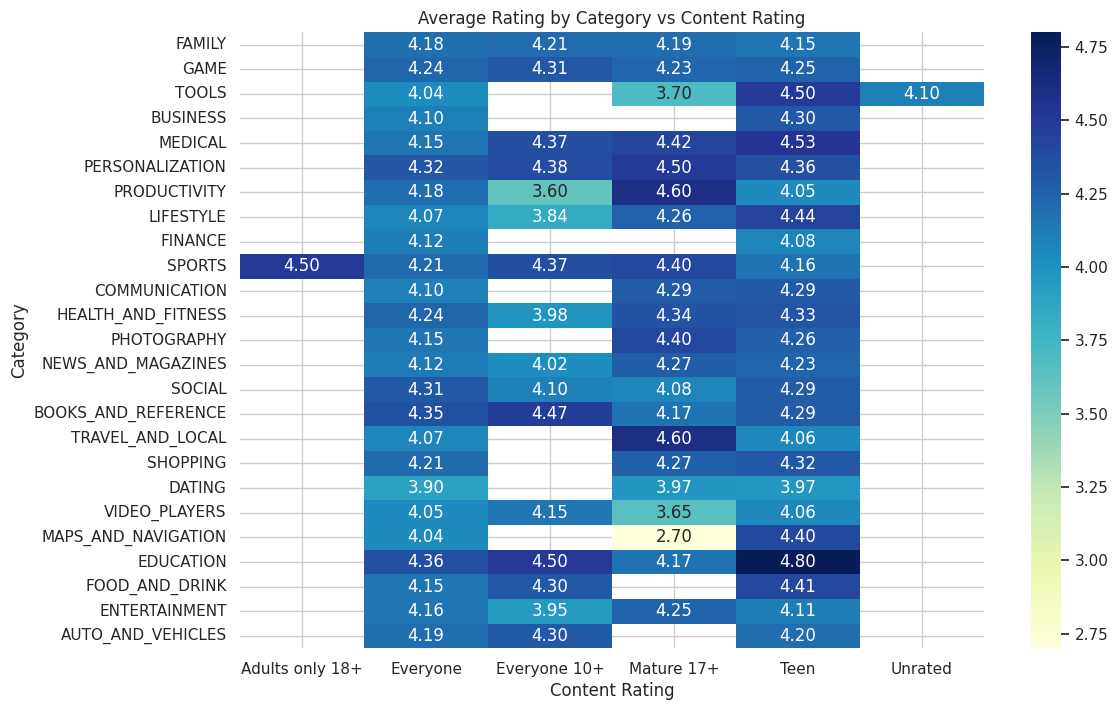

In [ ]:
pivot = apps.pivot_table(index='Category', columns='Content Rating', values='Rating', aggfunc='mean')
pivot = pivot.loc[topcats]
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Average Rating by Category vs Content Rating")
plt.show()

##Treemap / Sunburst of installs by Category (interactive)

/usr/local/lib/python3.12/dist-packages/squarify/__init__.py:173: RuntimeWarning:

invalid value encountered in scalar divide



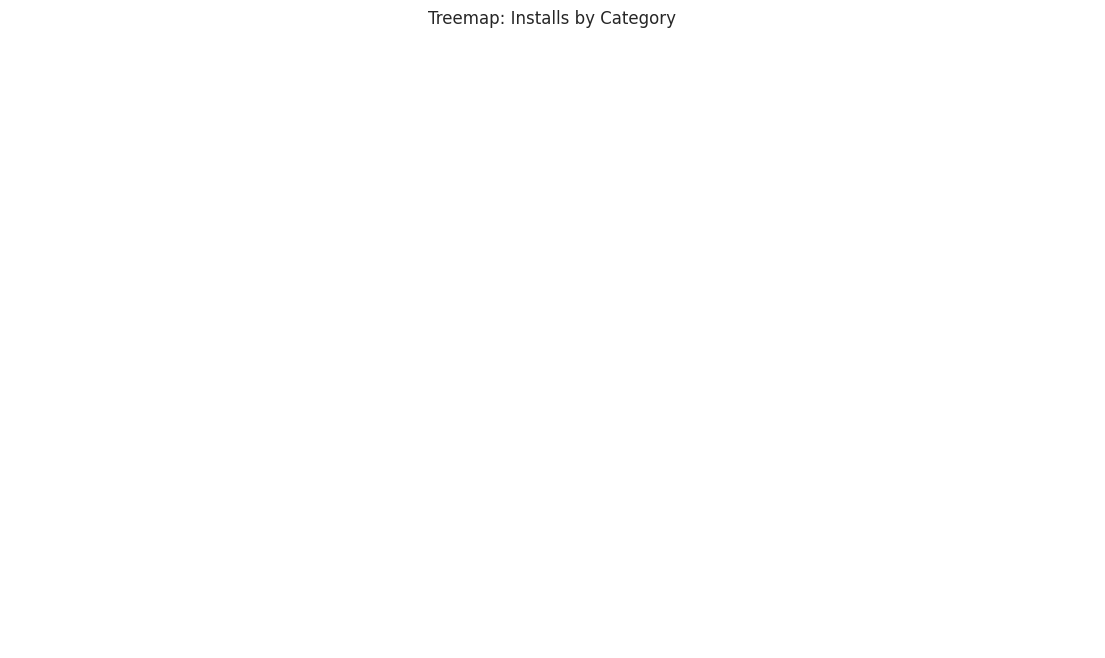

In [ ]:
cat_installs = apps.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(25)
plt.figure(figsize=(14,8))
squarify.plot(sizes=cat_installs.values, label=[f"{i}\n{v:,}" for i,v in zip(cat_installs.index, cat_installs.values)], alpha=.8)
plt.axis('off')
plt.title("Treemap: Installs by Category")
plt.show()

fig = px.sunburst(apps, path = ['Category', 'Genres'], values = 'Installs', title = 'Installs by Category and Genre (sunburst)' )
fig.show()

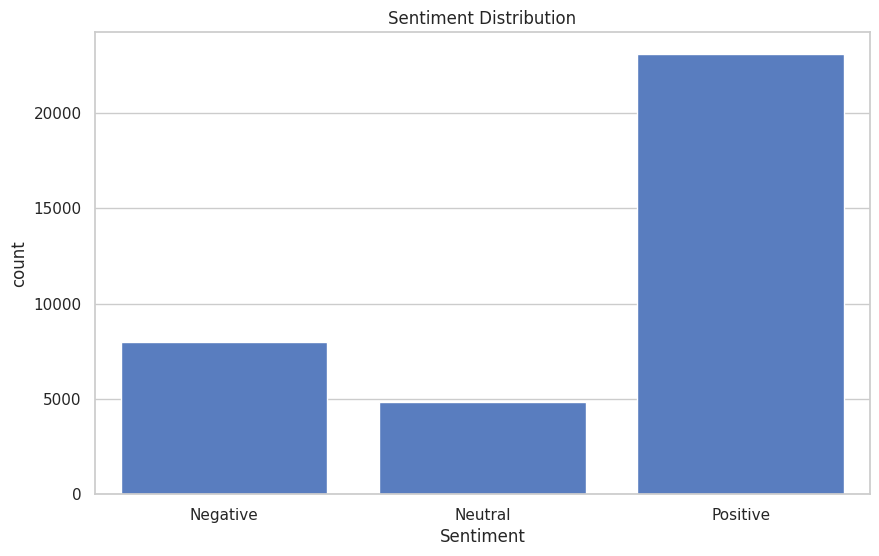

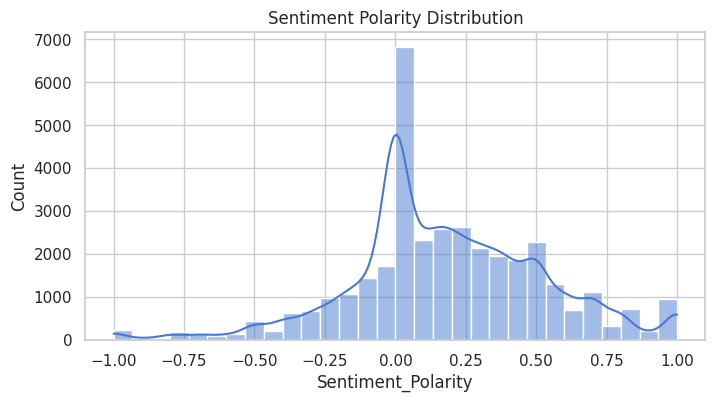

In [ ]:
merged = pd.merge(apps[['App', 'Category', 'Rating', 'Installs', 'Reviews', 'Price', 'Size_MB', 'Last Update']],
                  reviews[['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity', 'Sentiment_Subjectivity']],
                  on='App', how='left')
if 'Sentiment' in merged.columns:
  sns.countplot(x='Sentiment', data=merged)
  plt.title('Sentiment Distribution')
  plt.show()

  plt.figure(figsize=(8,4))
  sns.histplot(merged['Sentiment_Polarity'].dropna(), bins=30, kde=True)
  plt.title('Sentiment Polarity Distribution')
  plt.show()

In [ ]:
import pandas as pd

apps_df = pd.read_csv("apps.csv")
apps_dup_df =  pd.read_csv("apps (1).csv")
reviews_df = pd.read_csv("user_reviews.csv")

print(apps_df.head())
print(reviews_df.head())

   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size     Installs  Type Price  \
0  ART_AND_DESIGN     4.1      159  19.0      10,000+  Free     0   
1  ART_AND_DESIGN     3.9      967  14.0     500,000+  Free     0   
2  ART_AND_DESIGN     4.7    87510   8.7   5,000,000+  Free     0   
3  ART_AND_DESIGN     4.5   215644  25.0  50,000,000+  Free     0   
4  ART_AND_DESIGN     4.3      967   2.8     100,000+  Free     0   

  Content Rating                     Genres      Last Updated  \
0       Everyone               Art & Design   January 7, 2018   
1       Everyone  Art & Design;Pretend Play  J

In [ ]:
import pandas as pd
from textblob import TextBlob
df = pd.read_csv('user_reviews.csv')
df['TB_Polarity'] = df['Translated_Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

print(df.head())

                     App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  TB_Polarity  
0  Positive                1.00                0.533333         1.00  
1  Positive                0.25                0.288462         0.25  
2       NaN                 NaN                     NaN         0.00  
3  Positive                0.40                0.875000         0.40  
4  Positive                1.00                0.300000         1.00  


In [ ]:
import pandas as pd
from textblob import TextBlob

df = pd.read_csv('user_reviews.csv')
print(df.columns)
df['TB_Polarity'] = df['Translated_Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

print(df.head())

Index(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity'],
      dtype='object')
                     App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  TB_Polarity  
0  Positive                1.00                0.533333         1.00  
1  Positive                0.25                0.288462         0.25  
2       NaN                 NaN                     NaN         0.00  
3  Positive                0.40                0.875000         0.40  
4  Positive                1.00             

In [ ]:
from textblob import TextBlob
df['TB_Polarity'] = df['Translated_Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

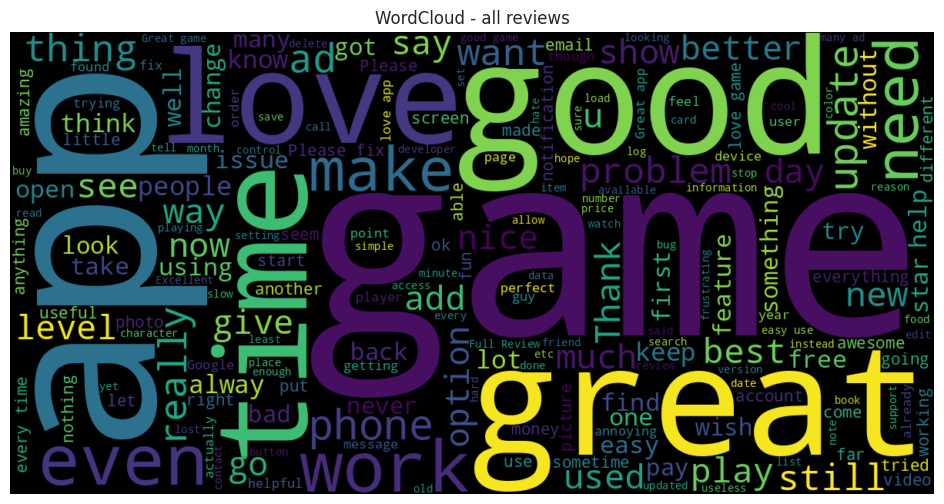

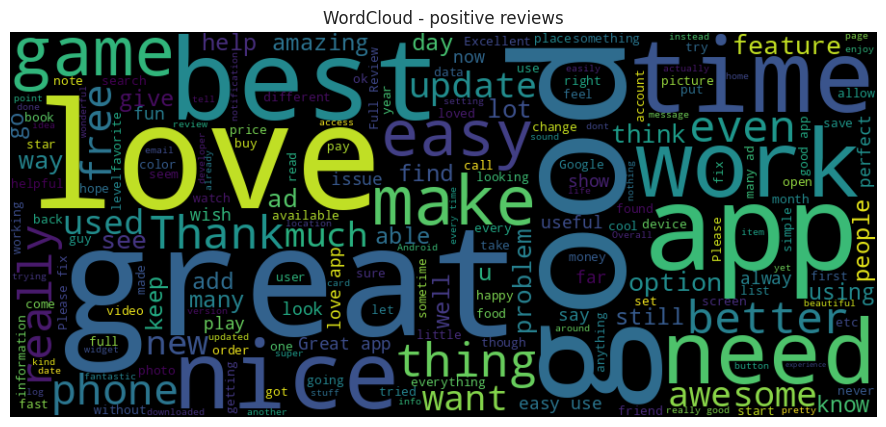

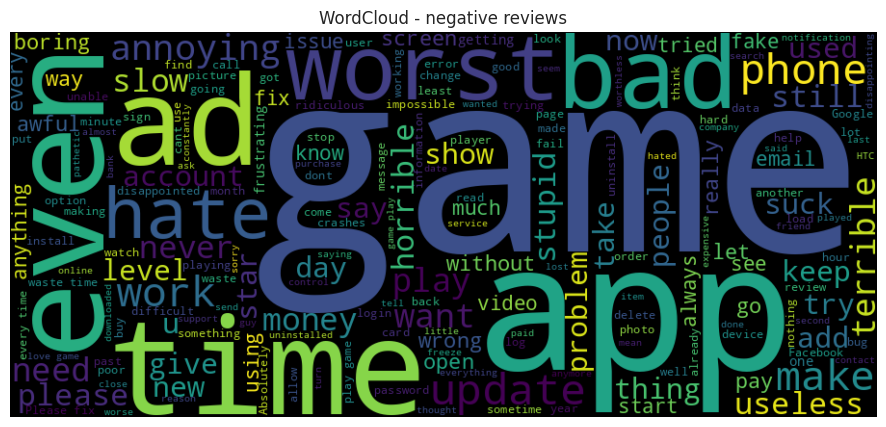

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

all_text = " ".join(df['Translated_Review'].dropna().astype(str).tolist())
stopwords = set(STOPWORDS)

if all_text:
  wc = WordCloud(width=1200, height=600, stopwords=stopwords, collocations=True).generate(all_text)
  plt.figure(figsize=(15,6))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title("WordCloud - all reviews")
  plt.show()

  pos_reviews_df = df[df['TB_Polarity'] > 0.2]
  pos_text = " ".join(pos_reviews_df['Translated_Review'].dropna().astype(str).tolist())

  if pos_text:
    wc_pos = WordCloud(width=900, height=400, stopwords=stopwords).generate(pos_text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud - positive reviews")
    plt.show()

  neg_reviews_df = df[df['TB_Polarity'] < -0.2]
  neg_text = " ".join(neg_reviews_df['Translated_Review'].dropna().astype(str).tolist())

  if neg_text:
    wc_neg = WordCloud(width=900, height=400, stopwords=stopwords).generate(neg_text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud - negative reviews")
    plt.show()

In [ ]:
from operator import neg
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(corpus, ngram_range=(1,1), top_n=20):
  vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  return words_freq[:top_n]

  pos_corpus = df[df['TB_Polarity'] > 0.2]['Translated_Review'].dropna().astype(str).tolist()
  neg_corpus = df[df['TB_Polarity'] < -0.2]['Translated_Review'].dropna().astype(str).tolist()

  print("Top positive unigrams:", top_ngrams(pos_corpus, (1,1),15))
  print("Top negative unigrams:", top_ngrams(neg_corpus, (1,1),15))

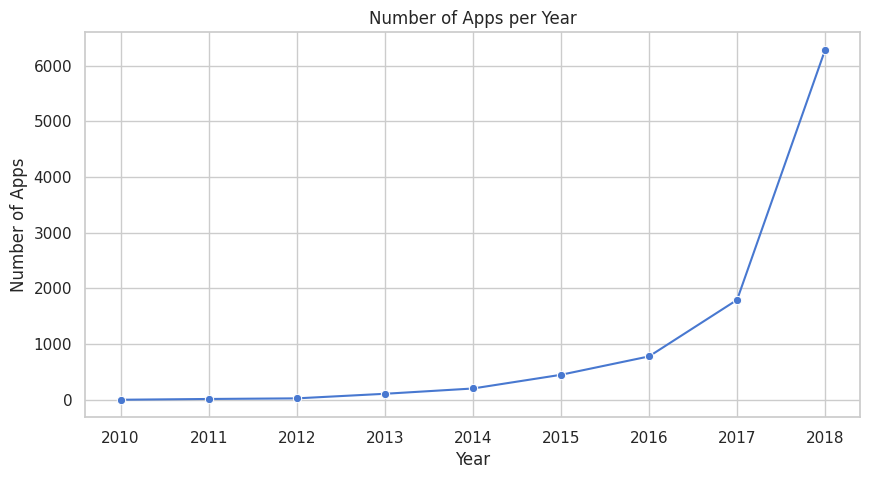

In [ ]:
apps['year_updated'] = apps['Last Update'].dt.year
year_counts = apps['year_updated'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker = 'o')
plt.title("Number of Apps per Year")
plt.xlabel("Year")
plt.ylabel("Number of Apps")
plt.show()

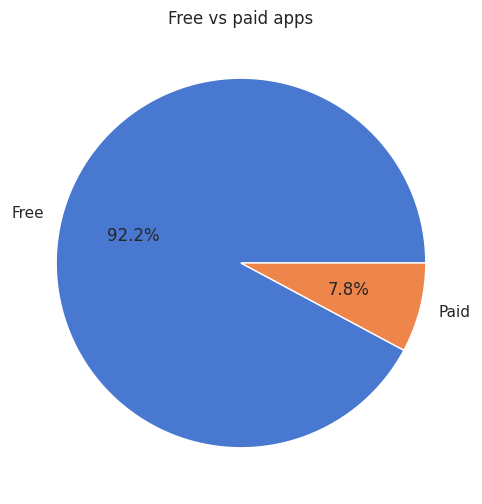

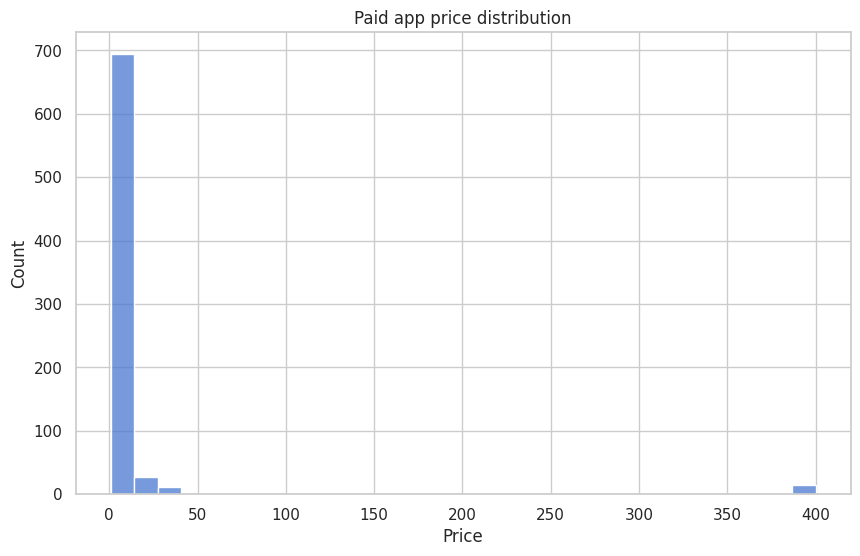

In [ ]:
if 'Type' in apps.columns:
  v = apps['Type'].value_counts()
  v.plot(kind='pie', autopct = '%1.1f%%', ylabel='')
  plt.title("Free vs paid apps")
  plt.show()

  paid = apps[apps['Price'] > 0]
  if not paid.empty:
    sns.histplot(paid['Price'], bins=30)
    plt.title("Paid app price distribution")
    plt.show()

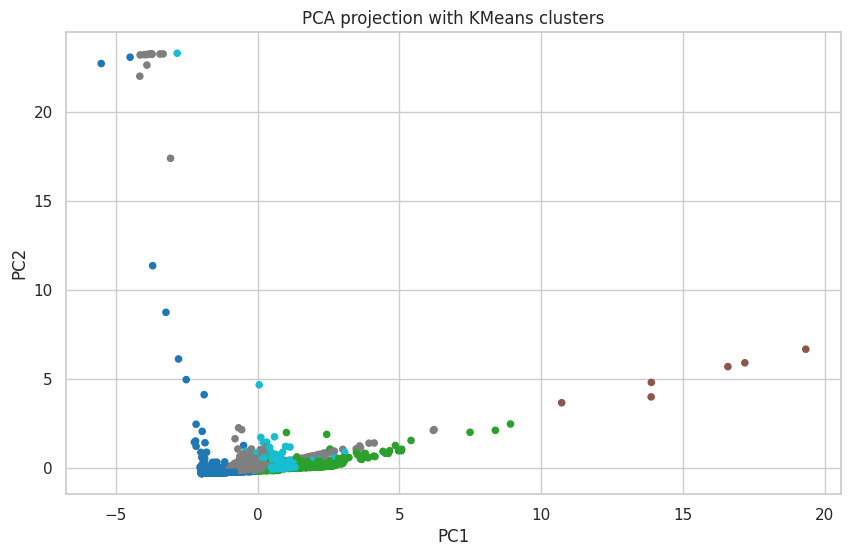

In [ ]:
X = apps[['Rating', 'Reviews', 'Installs', 'Size_MB', 'Price']].copy()
X = X.fillna(0)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', s=20)
plt.title("PCA projection with KMeans clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
apps.to_csv("cleaned_aaps.csv", index=False)
reviews.to_csv("cleaned_reviews.csv", index=False)
files.download("cleaned_aaps.csv")
files.download("cleaned_reviews.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>